# Analysis and Visualization of Complex Agro-Environmental Data
---
### Exercise #6 - correction

In [1]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns # For plotting
import matplotlib.pyplot as plt # For showing plots
import scipy.stats as sts
import scikit_posthocs as sp
import statsmodels.stats as stm
from statsmodels.graphics.gofplots import qqplot

##### Exercise 6.1 Using the EFIplus_medit.zip dataset, test if the frequency of sites with presence and absence of Salmo trutta fario (Brown Trout) are independent from the country. Please state which is/are the null hypothesis of your test(s). You may try to produce an alluvial plot!

In [2]:
df = pd.read_csv('../exemplos/EFIplus_medit.zip',compression='zip', sep=";")

In [3]:
# clean up the dataset to remove unnecessary columns (eg. REG) 
df.drop(df.iloc[:,5:15], axis=1, inplace=True)

# let's rename some columns so that they make sense
df.rename(columns={'Sum of Run1_number_all':'Total_fish_individuals'}, inplace=True) # inplace="True" means that df will be updated

# for sake of consistency, let's also make all column labels of type string
df.columns = list(map(str, df.columns))

In [4]:
# produce contingency table of Country and Samo trutta fario.
cdf = pd.crosstab(index=df['Country'], columns=df['Salmo trutta fario'])
print(cdf)

Salmo trutta fario     0     1
Country                       
France                13    59
Italy                109    76
Portugal             615   252
Spain               1239  2648


In [5]:
# Chi-square test of independency
stat, p, dof, expected = sts.chi2_contingency(cdf)
print('df=%d' % dof)
print('expected values:')
print(expected)

# Alternative 1: interpret based on test-statistic
prob=0.95
critical = sts.chi2.ppf(prob, dof)
print('critical=%.3f, stat=%.3f' % (critical, stat))
if abs(stat) >= critical:
 print('stat > critical => reject H0 that variables are independent')
else:
 print('stat < critical => fail to reject H0 that variables are independent')

 # Alternative 2: interpret based on p-value
alpha = 0.05
print('significance=%.2f, p=%.3f' % (alpha, p))
if p <= alpha:
 print('reject H0 that variables are independent')
else:
 print('fail to reject H0 that variables are independent')

df=3
expected values:
[[  28.39193774   43.60806226]
 [  72.95150669  112.04849331]
 [ 341.88625025  525.11374975]
 [1532.77030533 2354.22969467]]
critical=7.815, stat=496.372
stat > critical => reject H0 that variables are independent
significance=0.05, p=0.000
reject H0 that variables are independent


##### Exercise 6.2 Run the non-parametric equivalent of the test you used in exercise 5.3 and compare with the ANOVA test (5.2: Test whether there are differences in the mean elevation in the upstream catchment (Elevation_mean_catch) among the eight most sampled catchments. For which pairs of catchments are these diferences significant? Please state which is/are the null hypothesis of your test(s)).


In [6]:
# Remove rows with at least one missing value
df.dropna(subset=['Elevation_mean_catch'], inplace=True)

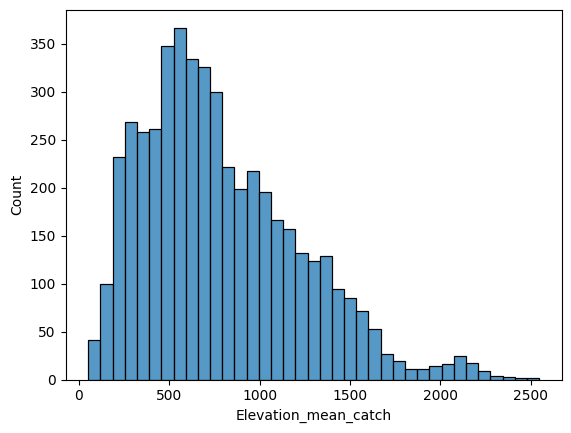

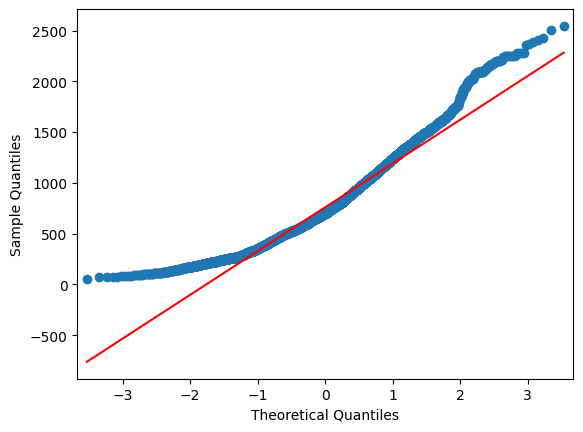

In [7]:
# Run histogram
sns.histplot(df['Elevation_mean_catch'])
plt.show()

# Run qq-plot
from statsmodels.graphics.gofplots import qqplot

qqplot(pd.Series(df['Elevation_mean_catch']), line='q')
plt.show()

In [8]:
catchment_count = pd.crosstab(index = df['Catchment_name'], columns='count')
catch_top8 = catchment_count.sort_values(by=['count'], ascending=False).head(8).index.to_list()
dfsub = df[df.Catchment_name.isin(catch_top8)]

<Axes: xlabel='Catchment_name', ylabel='Elevation_mean_catch'>

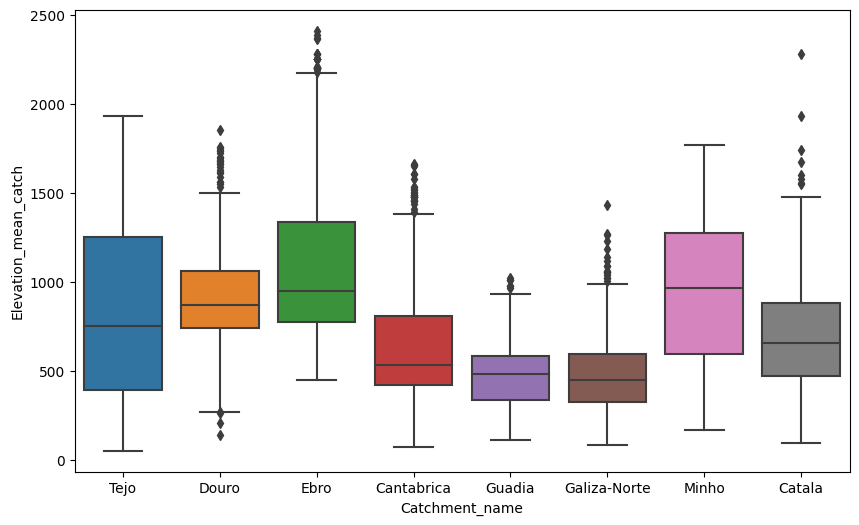

In [9]:
# Boxplots
plt.figure(figsize = (10,6))
sns.boxplot(data=dfsub, x='Catchment_name', y='Elevation_mean_catch')

In [10]:
# Run non-parametric equivalent to one-way ANOVA - Kruskal-Walis test

sample1 = df[(df['Catchment_name']=='Tejo')]['Elevation_mean_catch']
sample2 = df[(df['Catchment_name']=='Douro')]['Elevation_mean_catch']
sample3 = df[(df['Catchment_name']=='Ebro')]['Elevation_mean_catch']
sample4 = df[(df['Catchment_name']=='Cantabrica')]['Elevation_mean_catch']
sample5 = df[(df['Catchment_name']=='Guadia')]['Elevation_mean_catch']
sample6 = df[(df['Catchment_name']=='Galiza-Norte')]['Elevation_mean_catch']
sample7 = df[(df['Catchment_name']=='Minho')]['Elevation_mean_catch']
sample8 = df[(df['Catchment_name']=='Catala')]['Elevation_mean_catch']


stat, p = sts.kruskal(sample1, sample2, sample3, sample4, sample5, sample6, sample7, sample8)
print('F-statistics=%.3f, p=%.6f' % (stat, p))

alpha=0.05

if p <= alpha:
 print('reject H0 that median elevation values are equal among catchments')
else:
 print('fail to reject H0 that median elevation values are equal among catchments')

# Compute median values of Mean elevation for each catchment
dfsub[['Elevation_mean_catch','Catchment_name']].groupby('Catchment_name').median()


F-statistics=1335.373, p=0.000000
reject H0 that median elevation values are equal among catchments


,Elevation_mean_catch
Catchment_name,
Cantabrica,533.684235
Catala,656.838894
Douro,867.717830
Ebro,950.476307
Galiza-Norte,451.420868
Guadia,482.573216
Minho,967.462453
Tejo,749.450112


In [11]:
# Run Dunn test
sp.posthoc_dunn(a=dfsub, val_col='Elevation_mean_catch', group_col= 'Catchment_name', p_adjust = 'bonferroni')

,Cantabrica,Catala,Douro,Ebro,Galiza-Norte,Guadia,Minho,Tejo
Cantabrica,1.000000e+00,7.776285e-01,1.317420e-31,8.151841e-69,1.060456e-13,3.075474e-07,1.737715e-35,9.271577e-09
Catala,7.776285e-01,1.000000e+00,3.884022e-13,1.628849e-29,3.595515e-16,1.742541e-10,6.508382e-13,1.280597e-01
Douro,1.317420e-31,3.884022e-13,1.000000e+00,2.309299e-03,7.926606e-96,3.372119e-60,1.000000e+00,1.473248e-08
Ebro,8.151841e-69,1.628849e-29,2.309299e-03,1.000000e+00,6.749938e-189,1.457688e-106,2.625631e-07,1.605385e-28
Galiza-Norte,1.060456e-13,3.595515e-16,7.926606e-96,6.749938e-189,1.000000e+00,1.000000e+00,7.422061e-122,5.041730e-51
Guadia,3.075474e-07,1.742541e-10,3.372119e-60,1.457688e-106,1.000000e+00,1.000000e+00,9.038610e-68,1.769566e-29
Minho,1.737715e-35,6.508382e-13,1.000000e+00,2.625631e-07,7.422061e-122,9.038610e-68,1.000000e+00,2.084380e-08
Tejo,9.271577e-09,1.280597e-01,1.473248e-08,1.605385e-28,5.041730e-51,1.769566e-29,2.084380e-08,1.000000e+00


In [12]:
# ANOVA

import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('Elevation_mean_catch ~ Catchment_name',
                data=dfsub).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2) # typ is the type of anova type to perform ('I','II' or 'III' = 1,2,3)
print(aov_table) # provides the usual ANOVA table

alpha=0.05
p=aov_table['PR(>F)'][0]

if p <= alpha:
 print('reject H0 that mean elevation values are equal among catchments')
else:
 print('fail to reject H0 that mean elevation values are equal among catchments')

# compute mean elevation for eacch catchment
dfsub[['Elevation_mean_catch','Catchment_name']].groupby('Catchment_name').mean()


                      sum_sq      df           F         PR(>F)
Catchment_name  2.137395e+08     7.0  227.953983  1.369526e-285
Residual        5.315097e+08  3968.0         NaN            NaN
reject H0 that mean elevation values are equal among catchments


,Elevation_mean_catch
Catchment_name,
Cantabrica,656.245295
Catala,706.433633
Douro,924.403733
Ebro,1123.675167
Galiza-Norte,471.965912
Guadia,487.350581
Minho,947.234759
Tejo,824.568000


In [13]:
# Multiple comparisons - perform Tukey's test 
tukey = stm.multicomp.pairwise_tukeyhsd(endog=dfsub['Elevation_mean_catch'],
                          groups=dfsub['Catchment_name'],
                          alpha=0.05)
#display results
print(tukey)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
   group1       group2     meandiff p-adj    lower     upper   reject
---------------------------------------------------------------------
  Cantabrica       Catala   50.1883 0.7208  -42.1585  142.5351  False
  Cantabrica        Douro  268.1584    0.0  190.9443  345.3726   True
  Cantabrica         Ebro  467.4299    0.0   399.797  535.0628   True
  Cantabrica Galiza-Norte -184.2794    0.0   -252.02 -116.5388   True
  Cantabrica       Guadia -168.8947    0.0 -251.7428  -86.0466   True
  Cantabrica        Minho  290.9895    0.0  223.2126  358.7663   True
  Cantabrica         Tejo  168.3227    0.0    95.179  241.4664   True
      Catala        Douro  217.9701    0.0  124.2303  311.7099   True
      Catala         Ebro  417.2415    0.0  331.2221  503.2609   True
      Catala Galiza-Norte -234.4677    0.0 -320.5718 -148.3636   True
      Catala       Guadia -219.0831    0.0 -317.5154 -120.6507   True
      Catala        

##### Exercise 6.3 Using the winequality_red.csv file in the examples folder of the github repository, test which wine parameters discriminate the best between wine quality scores categorized into two classes using value 5 as the threshold value (quality>5=“good” and quality<5=“bad”).

In [15]:
df_wine = pd.read_csv('../exemplos/winequality_red.csv')
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
df_wine['quality'].head(30)

In [17]:
# Discretize quality values into "good" and "bad"
df_wine['quality_class'] = pd.cut(x=df_wine['quality'], bins=[0, 5, 10], labels=["bad","good"]) # NOTE: the bins intervals are closed to the left (])
pd.crosstab(index = df_wine['quality_class'], columns='count') # sample sizes are relatively balanced


col_0,count
quality_class,
bad,744
good,855


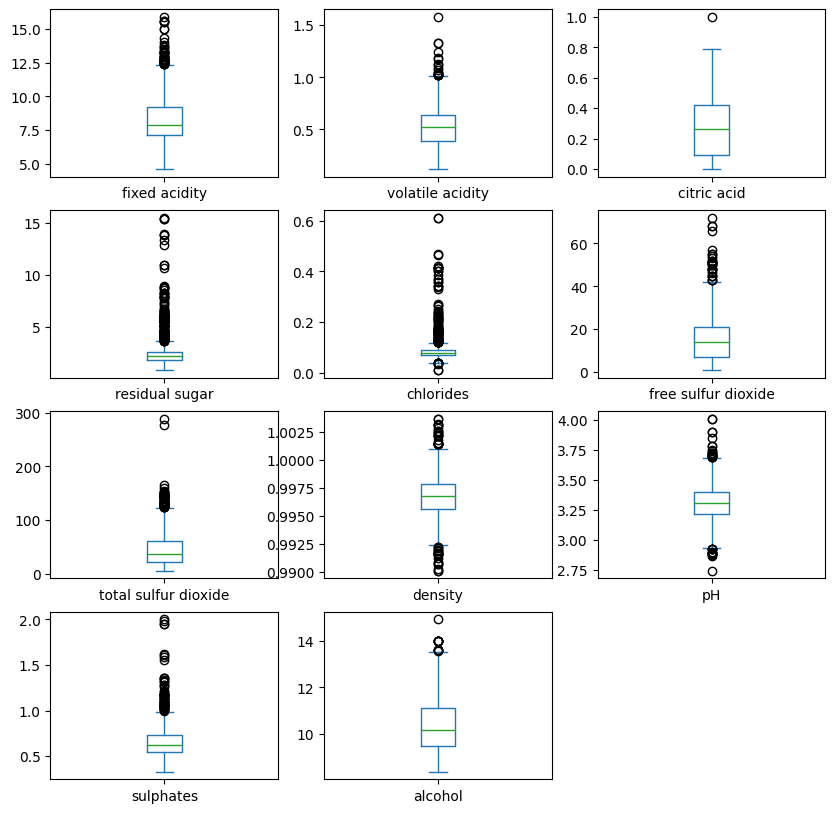

In [18]:
g = df_wine.iloc[:,0:11].plot.box(subplots=True, legend=True, layout=(4, 3), figsize=(10,10))
plt.show()

In [21]:
# Too many outliers => better to run a Mann-Whitney U test (two-tailed) for each variable

output_table = [] # define list of results

# run loop to test for each variable
for var in df_wine.columns[0:11]:
    bad = df_wine[df_wine['quality_class'] == 'bad'][var]
    good = df_wine[df_wine['quality_class'] == 'good'][var]
    stat, p = sts.mannwhitneyu(good, bad) # run Mann-Whitney U test
    output_table.append({'Variable': var,
                        'U statistic': stat,
                        'p-value': p}) # Append outputs

print(pd.DataFrame(output_table))

                Variable  U statistic       p-value
0          fixed acidity     347895.5  1.193549e-03
1       volatile acidity     197208.0  2.388474e-39
2            citric acid     376272.5  2.554688e-10
3         residual sugar     323150.5  5.797433e-01
4              chlorides     254091.0  3.719107e-12
5    free sulfur dioxide     298401.5  3.263965e-02
6   total sulfur dioxide     245006.0  2.136143e-15
7                density     257552.0  5.019222e-11
8                     pH     316157.5  8.363422e-01
9              sulphates     440968.0  1.177947e-40
10               alcohol     481313.0  2.006059e-70
